# NOTES:

- We need to find the total amount donated for opportunities.
- Do we proceed with just the donations with 100% certainty? Do we look at estimated amount? Actual amount received?
- We should group by City


## Opportunities dataset:
- We need to do some join operations to get the data together.
    - Join contact by ContactId
    - Group by activity sector to get donations by location
- Calculate opportunities won by location
- Calculate the total amount of money won, and expected to be won by location
- Why are we losing what we are losing. Where are we losing?


## ML Task:
- We need to group by date to get total payments by date. From this, we create the time-series dataset.



In [1]:
import pandas as pd
import os
from unidecode import unidecode
import numpy as np
import re

In [2]:
data = {}
for doc in os.listdir('data/shared_data_read_only'):
    try:
        data[doc] = pd.read_excel(f"data/shared_data_read_only/{doc}")
    except:
        continue

In [3]:
data.keys()

dict_keys(['consumer_price_index.xlsx', 'Items and Opportunities.xlsx', 'Data dictionary.xlsx', 'Invoice and Opportunities.xlsx', 'Business Account.xlsx', 'Opportunities.xlsx', 'Non-Stock Items.xlsx', 'Contacts.xlsx'])

In [5]:
data["Contacts.xlsx"]

,ContactID,Active,Business Account,Class,Class Name,Financing preference,Owner,Follow-up with,Postal Code,City,State,Code pays,Country Name,Gender,Client Source,Last Modified On,Created On
0,39405,True,C00091,01BUSIN,Business function,NaN,26.0,NaN,WC1V 6JS,London,NaN,GB,United Kingdom of Great Britain and Northern I...,NaN,NaN,2023-07-11 14:37:02.183,2021-06-03 08:35:32.823
1,41938,True,C06932,03PDG,DG,"Apprenticeship tax, Gala Lyon, But en Or Lyon,...",29.0,NaN,69120,VAULX EN VELIN,NaN,FR,France,NaN,NaN,2023-02-07 12:19:14.043,2022-01-05 16:34:58.807
2,37775,True,C01438,10DIRGENE,General Management,NaN,17.0,8.0,93701,DRANCY,NaN,FR,France,Male,NaN,2021-03-23 07:05:02.557,2021-03-19 06:44:36.557
3,37776,True,C01430,13ELU,Elected,NaN,17.0,8.0,93000,BOBIGNY,NaN,FR,France,Male,NaN,2021-03-23 07:05:03.410,2021-03-19 06:44:37.070
4,36942,True,C01204,13ELU,Elected,NaN,6.0,5.0,69140,RILLIEUX-LA-PAPE,NaN,FR,France,Male,NaN,2021-04-13 10:52:53.050,2021-03-17 16:45:45.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5506,38255,True,C01453,11DIRTER,Territorial Management,NaN,40.0,NaN,59100,ROUBAIX,NaN,FR,France,Female,NaN,2021-03-19 06:51:37.223,2021-03-19 06:51:37.223
5507,39179,True,C01884,01BUSIN,Business function,"Apprenticeship tax, Annual report",7.0,NaN,75010,PARIS,NaN,FR,France,Female,NaN,2021-05-17 11:23:30.993,2021-05-17 11:23:30.993
5508,40695,True,C03979,20PART,Individual,NaN,NaN,NaN,75010,Paris,NaN,FR,France,NaN,HelloAsso,2021-10-13 10:53:49.693,2021-10-13 10:53:49.693
5509,43323,True,C07697,02COM,Communication,"JDLV Ceremony, Annual report, Greetings",29.0,NaN,75007,PARIS,NaN,FR,France,NaN,NaN,2022-06-03 14:58:41.643,2022-05-09 13:45:01.623


In [4]:
# Opportunities Prep

data["Opportunities.xlsx"].rename(columns={"Contact ID": "ContactID"}, inplace=True)

# Preprcoessing Opportunities

# Many nan vals in ContactID

In [3]:
data["Opportunities.xlsx"].isna().sum()

Opportunity ID                                  0
Business Account                                2
Contact ID                                   3195
Estimated Close Date                            0
Status                                          0
Stage                                           0
Probability                                     0
Estimated amount                                0
Amount received                              3250
Difference                                      0
Owner Name                                    250
Follow-up with                               5001
Class ID                                        0
Class                                           0
Source                                       5445
Source Campaign                              4828
Campaign Name                                4828
Programme financé                            2136
Action financée                              5613
Agreement                                    2100


In [13]:
df[df.ContactID.isna()]

,Opportunity ID,Business Account,ContactID,Estimated Close Date,Status,Stage,Probability,Estimated amount,Amount received,Difference,...,Follow-up withcontacts,Postal Code,City,State,Code pays,Country Name,Gender,Client Source,Last Modified On,Created Oncontacts
38,6349,C21530,NaN,2023-10-10,New,Initial Prospect,20,25000.0,NaN,-25000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
39,6348,C21529,NaN,2023-10-10,New,Initial Prospect,20,150000.0,NaN,-150000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
40,6347,C21528,NaN,2023-10-10,New,Initial Prospect,20,100000.0,NaN,-100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
42,6345,C01325,NaN,2023-10-10,New,Initial Prospect,20,200000.0,NaN,-200000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
43,6344,C21527,NaN,2023-10-10,New,Initial Prospect,20,50000.0,NaN,-50000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,5,C00036,NaN,2020-01-01,Won,Won,100,1059.0,NaN,-1059.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
5982,4,C00024,NaN,2020-01-01,Won,Won,200,7500.0,7500.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
5983,3,C00011,NaN,2020-01-01,Won,Won,100,35000.0,NaN,-35000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
5984,2,C00331,NaN,2020-01-01,Won,Won,100,20000.0,NaN,-20000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


# Values in Class ID

In [26]:
data["Opportunities.xlsx"]["Class ID"].value_counts()

PPRIV MEC     2523
PPRIV EVNT    1251
PPRIV TA      1118
PPUB           425
CAMP SAL       267
CAMP TER       196
CAMP EVT       168
PPRIV DONN      28
PPRIV MCOM      10
Name: Class ID, dtype: int64

In [32]:
data["Opportunities.xlsx"]["Business Account"]

0       C00037
1       C01254
2       C21512
3       C21509
4       C21508
         ...  
5981    C00036
5982    C00024
5983    C00011
5984    C00331
5985    C00331
Name: Business Account, Length: 5986, dtype: object

In [31]:
data["Business Account.xlsx"]["Business Account"]

0       C00001
1       C00002
2       C00003
3       C00004
4       C00005
         ...  
3478    C19916
3479    C19917
3480    C19918
3481    C19986
3482    C19987
Name: Business Account, Length: 3483, dtype: object

In [36]:
data["Opportunities.xlsx"].dtypes

Opportunity ID                                        int64
Business Account                                     object
ContactID                                           float64
Estimated Close Date                         datetime64[ns]
Status                                               object
Stage                                                object
Probability                                           int64
Estimated amount                                    float64
Amount received                                     float64
Difference                                          float64
Owner Name                                          float64
Follow-up with                                      float64
Class ID                                             object
Class                                                object
Source                                               object
Source Campaign                                     float64
Campaign Name                           

In [38]:
data["Business Account.xlsx"].dtypes

Business Account                   object
Customer Status                    object
Type                               object
Partner type                       object
Class                              object
Class Name                         object
Activity sector                    object
Parent Business Account            object
Owner Name                        float64
Follow-up with                    float64
Postal Code                        object
City                               object
State                              object
Country ID                         object
Country Name                       object
Created On                 datetime64[ns]
Last Modified On           datetime64[ns]
dtype: object

# Join Operation

In [4]:
# Join on Business Accounts

df = data["Opportunities.xlsx"].merge(data["Business Account.xlsx"], on="Business Account", how="left")

In [26]:
df.shape

(5986, 59)

In [28]:
df = df.merge(data["Contacts.xlsx"], on="ContactID", how="left")

In [30]:
all_opportunities = data["Items and Opportunities.xlsx"].merge(data["Invoice and Opportunities.xlsx"], on="Opportunity ID")
all_opportunities = all_opportunities.merge(data["Non-Stock Items.xlsx"], on="Inventory ID")

In [31]:
df = df.merge(all_opportunities, on='Opportunity ID', how="left")

In [33]:
df

,Opportunity ID,Business Account_x,ContactID,Estimated Close Date,Status,Stage,Probability,Estimated amount,Amount received,Difference,...,Amount,Date,Description EN,Posting Class,Tax Category_y,Base Unit,Item Status,Created On_y,Last Modified On,Default Price
0,6387,C00037,35334.0,2023-11-27,New,Won,100,9000.0,NaN,-9000.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,6386,C01254,36240.0,2023-10-11,New,Won,100,9000.0,NaN,-9000.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,6385,C21512,47640.0,2023-10-11,New,Oral agreement,80,140.0,NaN,-140.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,6384,C21509,47636.0,2023-10-11,New,Oral agreement,80,350.0,NaN,-350.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,6383,C21508,47635.0,2023-10-10,New,Oral agreement,80,120.0,NaN,-120.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8017,5,C00036,NaN,2020-01-01,Won,Won,100,1059.0,NaN,-1059.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
8018,4,C00024,NaN,2020-01-01,Won,Won,200,7500.0,7500.0,0.0,...,7500.0,2021-07-02,Sponsorship,MECENAT,TVA0,PIECE,Active,2021-02-12 02:59:03.890,2021-09-01 10:39:46.240,0.0
8019,3,C00011,NaN,2020-01-01,Won,Won,100,35000.0,NaN,-35000.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
8020,2,C00331,NaN,2020-01-01,Won,Won,100,20000.0,NaN,-20000.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


# function

In [84]:
docs = ['consumer_price_index.xlsx',
         'Items and Opportunities.xlsx',
         'Invoice and Opportunities.xlsx',
         'Business Account.xlsx',
         'Opportunities.xlsx',
         'Non-Stock Items.xlsx',
         'Contacts.xlsx']

def load_and_join_data(docs):
    data = {}
    for doc in docs:
        try:
            data[doc] = pd.read_excel(f"data/shared_data_read_only/{doc}")
        except:
            continue
    data["Opportunities.xlsx"].rename(columns={"Contact ID": "ContactID"}, inplace=True)
    df = data["Opportunities.xlsx"].merge(data["Business Account.xlsx"], on="Business Account", how="left")
    all_opportunities = data["Items and Opportunities.xlsx"].merge(data["Invoice and Opportunities.xlsx"], on="Opportunity ID")
    all_opportunities = all_opportunities.merge(data["Non-Stock Items.xlsx"], on="Inventory ID")
    df = df.merge(data["Contacts.xlsx"], on="ContactID", how="left")
    df = df.merge(all_opportunities, on='Opportunity ID', how="left")
    df.drop(columns=df.filter(regex="_y").columns, inplace=True)
    df.columns = df.columns.str.replace('_x', '')    
    return df

In [85]:
# df = pd.read_csv("data/final_data.csv")
df, op = load_and_join_data(docs)

In [86]:
df["Amount received"].notna().sum()

4754

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

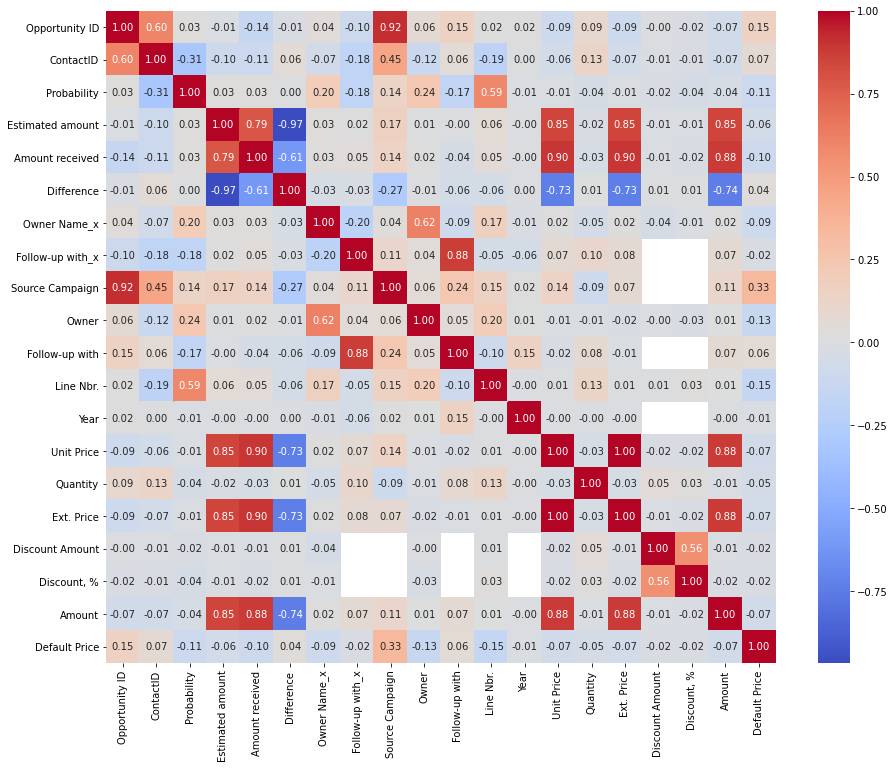

In [50]:
plt.figure(figsize=(15, 12))
corr_matrix= df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",)

# Exploration

### Stage and Status by country and city

In [5]:
df_op = data["Opportunities.xlsx"].merge(data["Business Account.xlsx"], on="Business Account", how="left")

In [27]:
df_op.columns

Index(['Opportunity ID', 'Business Account', 'Contact ID',
       'Estimated Close Date', 'Status', 'Stage', 'Probability',
       'Estimated amount', 'Amount received', 'Difference', 'Owner Name_x',
       'Follow-up with_x', 'Class ID', 'Class_x', 'Source', 'Source Campaign',
       'Campaign Name', 'Programme financé', 'Action financée', 'Agreement',
       'Signature date of the agreement', 'Agreement expiry date',
       'Duration of agreement (months)',
       'Deadline for submission of interim report', 'Final report deadline',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment date 1', 'Theorical payment amount 1',
       'Theorical payment date 2', 'Theorical payment amount 2',
       'Theorical payment date 3', 'Theorical payment amount 3',
       'Theorical payment date 4', 'Theorical payment amount 4',
       'Theorical payment date 5', 'Theorical payment amount 5',
       'Created On_x', 'Last Modified Date', 'Actual Close Date',
      

In [28]:
pd.crosstab(df_op["Stage"], df_op["Status"], normalize=0).style.background_gradient()

Status,Lost,New,Open,Won
Stage,,,,
Advanced Prospect,0.235849,0.613208,0.028302,0.122642
Dossier posed,0.347458,0.398305,0.050847,0.203390
Initial Prospect,0.267890,0.431193,0.078899,0.222018
Lost,0.441176,0.529412,0.029412,0.000000
Oral agreement,0.014801,0.547641,0.014801,0.422757
Won,0.006826,0.132374,0.009264,0.851536


In [6]:
df_op["Country Name"].value_counts()

France                                                  5659
United States of America                                  77
United Kingdom of Great Britain and Northern Ireland      42
États-Unis                                                37
Switzerland                                               14
Reunion !Réunion                                           9
Germany                                                    7
Italie                                                     4
Suisse                                                     4
Belgique                                                   3
Belgium                                                    3
Espagne                                                    2
Luxembourg                                                 2
Bermuda                                                    1
Allemagne                                                  1
Monaco                                                     1
Royaume-Uni             

In [7]:
def preprocess(df):
    df_op["Country Name"] = df_op["Country Name"].str.lower().apply(lambda x: unidecode(x) if isinstance(x, str) else np.nan)
    df_op["Country Name"] = df_op["Country Name"].replace("etats-unis", "united states of america")
    df_op["Country Name"] = df_op["Country Name"].replace("royaume-uni", "united kingdom of great britain and northern ireland")
    df_op["Country Name"] = df_op["Country Name"].replace("reunion !reunion", "reunion")
    return df

df_op = preprocess(df_op)

In [8]:
countries = pd.crosstab(df_op["Status"], df_op["Country Name"]).sum() > 10
filts = countries[countries==True].index

pd.crosstab(df_op["Status"], df_op["Country Name"]).loc[:, filts].style.background_gradient()


Country Name,france,switzerland,united kingdom of great britain and northern ireland,united states of america
Status,,,,
Lost,261,1,2,2
New,1338,3,8,35
Open,99,1,0,2
Won,3961,9,33,75


In [14]:

def clean_city_name(city):
    city = city.capitalize()
    city = city.replace("-", " ")
    city = city.replace("CEDEX", "")
    city = re.sub(r"\d", "", city)
    city = city.replace("‘", "")
    city = city.strip()
    return city

df_op["City"] = df_op["City"].astype(str).apply(clean_city_name)


In [10]:
df_op_fr = df_op[df_op["Country Name"] == "france"].copy()
df_op_fr["City"] = df_op_fr["City"].astype(str).apply(clean_city_name)


In [11]:
df_op_fr.groupby('City')["Status"].value_counts()

City                      Status
                          New       4
                          Won       2
                          Lost      1
Adresse  non communiquee  Won       1
Adresse incomplete        New       1
                                   ..
Wasquehal                 Won       8
                          New       3
                          Lost      2
Wattrelos                 New       1
Écully                    Won       1
Name: Status, Length: 712, dtype: int64

In [12]:
pd.crosstab(df_op_fr["City"], df_op_fr["Status"])

Status,Lost,New,Open,Won
City,,,,
,1,4,0,2
Adresse non communiquee,0,0,0,1
Adresse incomplete,0,1,0,0
Adresse non commmuniquee,0,0,0,1
Adresse non communiquee,1,2,0,38
...,...,...,...,...
Vulaines sur seine,0,0,0,1
Vélizy villacoublay,0,1,0,5
Wasquehal,2,3,0,8


In [15]:
# df_op_fr = df_op[df_op["Country Name"] == "france"].copy()
df_op_fr.groupby("City")["Status"].value_counts()

City                      Status
                          New       4
                          Won       2
                          Lost      1
Adresse  non communiquee  Won       1
Adresse incomplete        New       1
                                   ..
Wasquehal                 Won       8
                          New       3
                          Lost      2
Wattrelos                 New       1
Écully                    Won       1
Name: Status, Length: 712, dtype: int64

### Customer Type

In [16]:
df_op["Country Name"].value_counts()

france                                                  5659
united states of america                                 114
united kingdom of great britain and northern ireland      43
switzerland                                               14
reunion                                                    9
germany                                                    7
italie                                                     4
suisse                                                     4
belgique                                                   3
belgium                                                    3
luxembourg                                                 2
espagne                                                    2
allemagne                                                  1
bermuda                                                    1
monaco                                                     1
Name: Country Name, dtype: int64

In [175]:
pd.crosstab(df_op["Type"], df_op["Country Name"])

Country Name,allemagne,belgique,belgium,bermuda,espagne,france,germany,italie,luxembourg,monaco,reunion,suisse,switzerland,united kingdom of great britain and northern ireland,united states of america
Type,,,,,,,,,,,,,,,
Business Account,1,3,0,0,1,535,0,0,0,1,0,2,0,1,15
Customer,0,0,3,1,1,5124,7,4,2,0,9,2,14,42,99


In [33]:
df_op[df_op["Type"] == "Business Account"]["Estimated amount"].mean()

13707.645295169947

In [34]:
df_op.groupby("Type")["Estimated amount"].mean()

Type
Business Account    13707.645295
Customer            23401.106153
Name: Estimated amount, dtype: float64

In [153]:
df_op["Type"].isna().sum()

119

In [158]:
df_op["Class Name"].value_counts()

Headquarters           2572
Individual              929
Foundation              634
Regional direction      392
State                   206
Local Authority         200
Agency                   81
US - United States       74
UK - United Kingdom       8
Store                     6
European Union            2
Name: Class Name, dtype: int64

In [155]:
df_op["Type"].value_counts()

Customer            5308
Business Account     559
Name: Type, dtype: int64

### Difference and Amount Received by country and city

- Business Account
- ContactID
- Country
- City

In [90]:
df_op[["Amount received", "Estimated amount", "Difference"]].isna().sum()

Amount received     3250
Estimated amount       0
Difference             0
dtype: int64

In [179]:
df_op["Amount received"].value_counts()

10000.00    159
5000.00     139
3000.00     104
1000.00      87
8000.00      82
           ... 
31699.17      1
4737.59       1
2800.75       1
491.00        1
2692.91       1
Name: Amount received, Length: 945, dtype: int64

In [17]:
df_op["Amount received"].isna().sum()

3250

In [18]:
train_df = df_op[df_op["Amount received"].notna()].copy()

In [19]:
train_df["Amount received"].isna().sum()

0

In [22]:
train_df["Diff_perc"] = train_df["Difference"] / train_df["Amount received"]
train_df["Diff_perc"] = train_df["Diff_perc"].replace(np.inf,np.nan).replace(-np.inf, np.nan)
train_df = train_df[train_df["Diff_perc"].isna()]

In [39]:
train_df.dtypes

Opportunity ID                                        int64
Business Account                                     object
Contact ID                                          float64
Estimated Close Date                         datetime64[ns]
Status                                               object
Stage                                                object
Probability                                           int64
Estimated amount                                    float64
Amount received                                     float64
Difference                                          float64
Owner Name_x                                        float64
Follow-up with_x                                    float64
Class ID                                             object
Class_x                                              object
Source                                               object
Source Campaign                                     float64
Campaign Name                           

In [149]:
df_op_fr["City"].isna().sum()

101

<AxesSubplot:title={'center':'Difference by Country'}, xlabel='Country ID'>

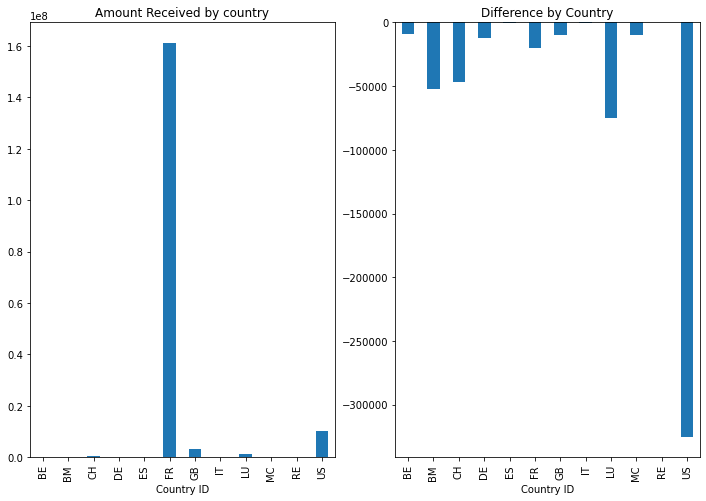

In [108]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
df.groupby("Country ID")["Amount received"].sum().plot(kind="bar", title="Amount Received by country", ax=ax[0])
df.groupby("Country ID")["Difference"].mean().plot(kind="bar", title="Difference by Country", ax=ax[1])


<AxesSubplot:title={'center':'By Class'}, xlabel='Class'>

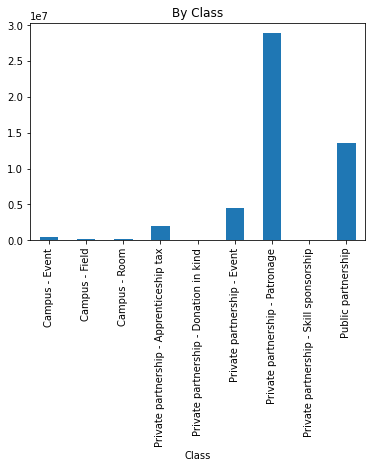

In [103]:
df_op.groupby("Class")["Amount received"].sum().plot(kind="bar", title="By Class")

<AxesSubplot:title={'center':'By Class'}, xlabel='Class ID'>

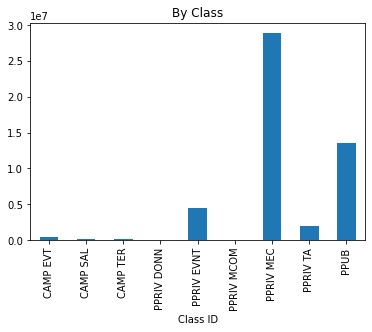

In [104]:
df_op.groupby("Class ID")["Amount received"].sum().plot(kind="bar", title="By Class")

In [ ]:
df_op.groupby("Class ID")["Difference"]

# Where estimates go wrong

In [ ]:
df["Difference"]

# Relevant cols
- training set is data


In [70]:
df["Difference"].isna().sum()

0

In [68]:
cols = ["Class_x", ]

4754

<AxesSubplot:>

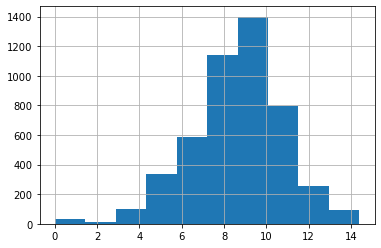

In [77]:
df["log_amount_received"] = np.log(1+df["Amount received"]).hist()

<AxesSubplot:>

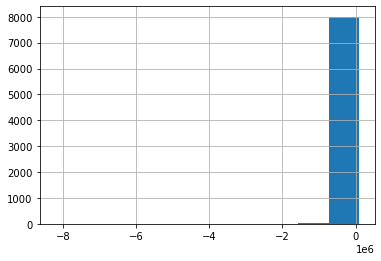

In [78]:
df["Difference"]

In [246]:
df_op.columns

Index(['Opportunity ID', 'Business Account', 'Contact ID', 'Status', 'Stage',
       'Probability', 'Estimated amount', 'Amount received', 'Difference',
       'Owner Name', 'Follow-up with', 'Class ID', 'Class', 'Source',
       'Source Campaign', 'Campaign Name', 'Programme financé',
       'Action financée', 'Agreement', 'Duration of agreement (months)',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment amount 1', 'Theorical payment amount 2',
       'Theorical payment amount 3', 'Theorical payment amount 4',
       'Theorical payment amount 5', 'Branch ID', 'Estimated Close Date_year',
       'Estimated Close Date_month', 'Estimated Close Date_day',
       'Signature date of the agreement_year',
       'Signature date of the agreement_month',
       'Signature date of the agreement_day', 'Agreement expiry date_year',
       'Agreement expiry date_month', 'Agreement expiry date_day',
       'Deadline for submission of interim report_year',
     

# Modelling

In [218]:
docs = ['consumer_price_index.xlsx',
         'Items and Opportunities.xlsx',
         'Invoice and Opportunities.xlsx',
         'Business Account.xlsx',
         'Opportunities.xlsx',
         'Non-Stock Items.xlsx',
         'Contacts.xlsx']

def load_and_join_data(docs):
    data = {}
    for doc in docs:
        try:
            data[doc] = pd.read_excel(f"data/shared_data_read_only/{doc}")
        except:
            continue
    data["Opportunities.xlsx"].rename(columns={"Contact ID": "ContactID"}, inplace=True)
    df = data["Opportunities.xlsx"].merge(data["Business Account.xlsx"], on="Business Account", how="left")
    all_opportunities = data["Items and Opportunities.xlsx"].merge(data["Invoice and Opportunities.xlsx"], on="Opportunity ID")
    all_opportunities = all_opportunities.merge(data["Non-Stock Items.xlsx"], on="Inventory ID")
    df = df.merge(data["Contacts.xlsx"], on="ContactID", how="left")
    df = df.merge(all_opportunities, on='Opportunity ID', how="left")
    df.drop(columns=df.filter(regex="_y").columns, inplace=True)
    df.columns = df.columns.str.replace('_x', '')    
    return df

df = load_and_join_data(docs)

In [219]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]

In [220]:
df["Target"] = (1- df["Amount received"]/df["Estimated amount"]).replace(np.inf, np.nan).replace(-np.inf, np.nan)

In [221]:
df = df[df["Target"].notna()].drop(columns=["Amount received", "Difference", "Amount"])


In [222]:
df["Country Name"].isna().sum()

23

In [223]:
to_drop = pd.Series([
    'Opportunity ID', "Probability", "State"
    'Signature date of the agreement', "Status",
   'Agreement expiry date', 'Deadline for submission of interim report',
   'Final report deadline', 'Theorical payment date 1',
   'Theorical payment date 2', 'Theorical payment date 3', 'Created On'
   'Theorical payment date 4', 'Theorical payment date 5','Assignment Date',
   'Created On_y', 'Last Modified On', 'Last Modified Date', 'Last Modified On',
    'Theorical payment amount 2', 'Theorical payment amount 3',
    'Theorical payment amount 4', 'Theorical payment amount 5', "Item Status", "Currency"])

df = df.drop(columns=to_drop[to_drop.isin(df.columns)])

most_nans = (df.isna().sum() > 3000)
nans = most_nans[most_nans].index
df = df.drop(columns=nans)

In [224]:
df.isna().sum()

Business Account           0
ContactID               1747
Estimated Close Date       0
Stage                      0
Estimated amount           0
Owner Name                19
Class ID                   0
Class                      0
Programme financé       2409
Agreement               2563
Type de financement     2572
Zone SDLV               2571
Created On                 0
Actual Close Date        873
Branch ID                  0
Customer Status           23
Type                      23
Partner type             490
Class Name               602
Activity sector          856
Postal Code               45
City                      65
Country ID                23
Country Name              23
Active                  1747
Owner                   2106
Code pays               1747
Line Nbr.                  1
Inventory ID               1
Year                     861
Unit Price                 1
Quantity                   1
UOM                       15
Ext. Price                 1
Discount Amoun

In [225]:
def clean_city_name(city):
    city = city.capitalize()
    city = city.replace("-", " ")
    city = city.replace("CEDEX", "")
    city = re.sub(r"\d", "", city)
    city = city.replace("‘", "")
    city = city.strip()
    return city

def _encode_dates(X, colname_):
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, f"{colname_}_year"] = X[f"{colname_}"].dt.year
    X.loc[:, f"{colname_}_month"] = X[f"{colname_}"].dt.month
    X.loc[:, f"{colname_}_day"] = X[f"{colname_}"].dt.day
    # X.loc[:, f"{colname_}_weekday"] = X[f"{colname_}"].dt.weekday

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=colname_)

def replace_infrequent_values(series, threshold=3, replacement='Other'):
    # Count the occurrences of each value in the Series
    value_counts = series.value_counts()

    # Get a list of values that occur less than the threshold
    infrequent_values = value_counts[value_counts < threshold].index

    # Replace infrequent values with the specified replacement
    series = series.apply(lambda x: replacement if x in infrequent_values else x)

    return series



In [226]:
df["City"] = df["City"].astype(str).apply(clean_city_name)
datecols = df.select_dtypes(include="datetime").columns
for col in datecols:
    df = _encode_dates(df, col)
df["Country Name"] = replace_infrequent_values(df["Country Name"], threshold=12)
df["Description EN"] = replace_infrequent_values(df["Description EN"], threshold=20)

<AxesSubplot:>

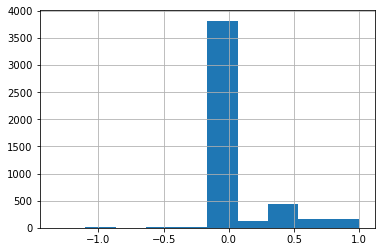

In [227]:
df["Target"].hist()

In [228]:
df.columns

Index(['Business Account', 'ContactID', 'Stage', 'Estimated amount',
       'Owner Name', 'Class ID', 'Class', 'Programme financé', 'Agreement',
       'Type de financement', 'Zone SDLV', 'Branch ID', 'Customer Status',
       'Type', 'Partner type', 'Class Name', 'Activity sector', 'Postal Code',
       'City', 'Country ID', 'Country Name', 'Active', 'Owner', 'Code pays',
       'Line Nbr.', 'Inventory ID', 'Year', 'Unit Price', 'Quantity', 'UOM',
       'Ext. Price', 'Discount Amount', 'Discount, %', 'Funded Program',
       'Free Item', 'Tax Category', 'Reference Nbr.', 'Customer',
       'Description EN', 'Posting Class', 'Base Unit', 'Default Price',
       'Target', 'Estimated Close Date_year', 'Estimated Close Date_month',
       'Estimated Close Date_day', 'Created On_year', 'Created On_month',
       'Created On_day', 'Actual Close Date_year', 'Actual Close Date_month',
       'Actual Close Date_day', 'Date_year', 'Date_month', 'Date_day'],
      dtype='object')

In [229]:
df.select_dtypes(include="object")

,Business Account,Stage,Class ID,Class,Programme financé,Agreement,Type de financement,Zone SDLV,Branch ID,Customer Status,...,Inventory ID,UOM,Funded Program,Free Item,Tax Category,Reference Nbr.,Customer,Description EN,Posting Class,Base Unit
146,C00137,Oral agreement,CAMP TER,Campus - Field,NaN,NaN,NaN,NaN,SDLV,Active,...,CAMP023,HEURE,NaN,False,TVA 20,FC0004543,C00137,Soccer pitch rental,CAMPUS,HEURE
166,C13140,Oral agreement,CAMP TER,Campus - Field,NaN,NaN,NaN,NaN,SDLV,Active,...,CAMP023,HEURE,NaN,False,TVA 20,FC0004530,C13140,Soccer pitch rental,CAMPUS,HEURE
167,C13140,Oral agreement,CAMP TER,Campus - Field,NaN,NaN,NaN,NaN,SDLV,Active,...,CAMP023,HEURE,NaN,False,TVA 20,FC0004529,C13140,Soccer pitch rental,CAMPUS,HEURE
212,C00094,Won,PPRIV EVNT,Private partnership - Event,NaN,NaN,NaN,NaN,SDLV,Active,...,EVEN001,PIECE,Non specified,False,TVA0,FC0004533,C00094,Gala table Lyon,EVENT,PIECE
259,C21171,Won,PPRIV MEC,Private partnership - Patronage,Non fléché,False,Fonctionnement,National,SDLV,NaN,...,MECENAT,PIECE,Non specified,False,TVA0,FC0004511,C21171,Sponsorship,MECENAT,PIECE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8013,C00036,Won,PPRIV MEC,Private partnership - Patronage,Job dans la Ville,True,Fonctionnement,National,SDLV,Active,...,MECENAT,PIECE,Job dans la Ville,False,0,FC0000204,C00036,Sponsorship,MECENAT,PIECE
8014,C00036,Won,PPRIV MEC,Private partnership - Patronage,Job dans la Ville,True,Fonctionnement,National,SDLV,Active,...,MECENAT,PIECE,Job dans la Ville,False,TVA0,FC0000304,C00036,Sponsorship,MECENAT,PIECE
8015,C00036,Won,PPRIV MEC,Private partnership - Patronage,Job dans la Ville,True,Fonctionnement,National,SDLV,Active,...,MECENAT,PIECE,Job dans la Ville,False,TVA0,FC0000205,C00036,Sponsorship,MECENAT,PIECE
8016,C00036,Won,PPRIV MEC,Private partnership - Patronage,Job dans la Ville,True,Fonctionnement,National,SDLV,Active,...,MECENAT,PIECE,Job dans la Ville,False,TVA0,FC0000204,C00036,Sponsorship,MECENAT,PIECE


In [ ]:
df.groupby()

# Model

In [353]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error




In [206]:
# Define the column transformer and the pipeline
object_cols = df.select_dtypes(include=['object']).columns

# Create a column transformer that applies label encoding to object columns
encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('label', encoder, object_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline that first applies label encoding and then any remaining transformations
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Fit and transform your DataFrame using the pipeline
transformed_data = pipeline.fit_transform(df.drop(columns="Target"))

# Create a DataFrame with original column names for the transformed data


In [207]:
X = pd.DataFrame(transformed_data.todense(), columns=preprocessor.get_feature_names())
X.shape

(4753, 6866)

In [208]:
y = df["Target"]
y.shape

(4753,)

In [209]:
df["Target"].mean()

0.08944828242881787

In [210]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (for regression, you can use Mean Squared Error, RMSE, etc.)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.08


In [211]:
pd.DataFrame({"y_pred":y_pred, "y_true": y_test})

,y_pred,y_true
3232,0.857430,0.848487
2771,0.000888,0.000000
983,0.000888,0.000000
3879,0.000888,0.000000
6223,-0.046378,0.000000
...,...,...
4778,-0.001352,0.000000
4598,0.000888,0.000000
4205,0.000888,0.000000
2965,0.000888,0.000000


In [186]:
df["Amount"]

146     1300.00
166      208.00
167       56.00
212     9000.00
259     7620.00
         ...   
8013    3324.00
8014     209.08
8015     209.08
8016    3324.00
8018    7500.00
Name: Amount, Length: 4753, dtype: float64

In [212]:
pd.Series(model.feature_importances_, index=preprocessor.get_feature_names()).sort_values()[-50:]

label__x26_FC0001619           0.003632
label__x26_FC0001188           0.003665
label__x26_FC0001191           0.003665
label__x26_FC0001480           0.003670
label__x26_FC0000316           0.003711
label__x0_C14618               0.003723
label__x0_C04297               0.003724
label__x0_C00510               0.003735
Date_year                      0.003896
label__x20_EVEN040             0.003996
label__x0_C01444               0.003999
label__x0_C00622               0.004320
Created On_month               0.004391
label__x0_C06247               0.004512
label__x0_C01202               0.004592
label__x0_C00714               0.004835
label__x6_Fonctionnement       0.004847
label__x0_C00876               0.004950
label__x26_FC0004091           0.004953
label__x0_C01404               0.004961
Date_month                     0.005329
label__x0_C01561               0.005605
label__x5_False                0.006239
label__x0_C01562               0.007031
label__x5_True                 0.007115


In [217]:
df.select_dtypes(include="object")["Currency"].value_counts()

EUR    4751
USD       1
Name: Currency, dtype: int64

# Only most important cols

In [381]:
df_op = data["Opportunities.xlsx"].copy()


In [288]:
df_op = data["Opportunities.xlsx"]

datecols = df_op.select_dtypes(include="datetime").columns

for col in datecols:
    df_op = _encode_dates(df_op, col)

In [248]:
df_op["Amount received"].isna().value_counts()

True     3250
False    2736
Name: Amount received, dtype: int64

In [249]:
df_op = df_op[df_op["Amount received"].notna()]

In [250]:
X = df_op.copy()
y = X.pop("Difference")


In [257]:
df_op.groupby(["Assignment Date_year"])["Difference"].sum()

Assignment Date_year
2021.0    -7145162.76
2022.0   -13565040.68
2023.0    -1318315.00
Name: Difference, dtype: float64

In [258]:
df_op.columns

Index(['Opportunity ID', 'Business Account', 'Contact ID', 'Status', 'Stage',
       'Probability', 'Estimated amount', 'Amount received', 'Difference',
       'Owner Name', 'Follow-up with', 'Class ID', 'Class', 'Source',
       'Source Campaign', 'Campaign Name', 'Programme financé',
       'Action financée', 'Agreement', 'Duration of agreement (months)',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment amount 1', 'Theorical payment amount 2',
       'Theorical payment amount 3', 'Theorical payment amount 4',
       'Theorical payment amount 5', 'Branch ID', 'Estimated Close Date_year',
       'Estimated Close Date_month', 'Estimated Close Date_day',
       'Signature date of the agreement_year',
       'Signature date of the agreement_month',
       'Signature date of the agreement_day', 'Agreement expiry date_year',
       'Agreement expiry date_month', 'Agreement expiry date_day',
       'Deadline for submission of interim report_year',
     

In [272]:
df["Actual Close Date_year"]

146     2023.0
166     2023.0
167     2023.0
212     2023.0
259     2023.0
         ...  
8013    2022.0
8014    2022.0
8015    2022.0
8016    2022.0
8018    2021.0
Name: Actual Close Date_year, Length: 4753, dtype: float64

In [275]:
df_op.groupby("Actual Close Date_year")[["Amount received", "Estimated amount", "Difference"]].sum()

,Amount received,Estimated amount,Difference
Actual Close Date_year,,,
2021.0,6409370.26,6503944.62,-94574.36
2022.0,14309945.66,14913056.78,-603111.12
2023.0,13036044.86,13149039.86,-112995.00


In [318]:
object_cols = df_op.select_dtypes(include="object").columns
pipeline.fit_transform(X)

TypeError: The DTypes <class 'numpy.dtype[timedelta64]'> and <class 'numpy.dtype[float64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [ ]:
cols = ["Class Name", ""]

In [119]:
df["Class Name"]

146     Headquarters
166              NaN
167              NaN
212     Headquarters
259              NaN
            ...     
8013    Headquarters
8014    Headquarters
8015    Headquarters
8016    Headquarters
8018      Foundation
Name: Class Name, Length: 4753, dtype: object

In [295]:
df_op["Duration of agreement (months)"].isna().sum()


5687

In [297]:
df_op.columns


Index(['Opportunity ID', 'Business Account', 'Contact ID',
       'Estimated Close Date', 'Status', 'Stage', 'Probability',
       'Estimated amount', 'Amount received', 'Difference', 'Owner Name',
       'Follow-up with', 'Class ID', 'Class', 'Source', 'Source Campaign',
       'Campaign Name', 'Programme financé', 'Action financée', 'Agreement',
       'Signature date of the agreement', 'Agreement expiry date',
       'Duration of agreement (months)',
       'Deadline for submission of interim report', 'Final report deadline',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment date 1', 'Theorical payment amount 1',
       'Theorical payment date 2', 'Theorical payment amount 2',
       'Theorical payment date 3', 'Theorical payment amount 3',
       'Theorical payment date 4', 'Theorical payment amount 4',
       'Theorical payment date 5', 'Theorical payment amount 5', 'Created On',
       'Last Modified Date', 'Actual Close Date', 'Assignment Da

In [322]:
df_op["Delay"] = df_op["Estimated Close Date"] - df_op["Actual Close Date"]

In [323]:
df_op["Status"].value_counts()

Won     4108
New     1500
Lost     271
Open     107
Name: Status, dtype: int64

In [378]:
X = df_op[df_op["Status"].isin(["Won", "Lost"])].copy()

In [380]:
y = X.pop("Delay").dt.days
y.clip(lower=-500)

KeyError: 'Delay'

In [329]:
datecols = df_op.select_dtypes(include="datetime").columns

for col in datecols:
    X = _encode_dates(X, col)

In [349]:
timed = (X.dtypes == "timedelta64[ns]")
timed[timed]

Delay    True
dtype: bool

In [355]:
# Define the column transformer and the pipeline
object_cols = X.select_dtypes(include=['object']).columns

# Create a column transformer that applies label encoding to object columns
encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('label', encoder, object_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline that first applies label encoding and then any remaining transformations
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Fit and transform your DataFrame using the pipeline
transformed_data = pipeline.fit_transform(X)
X = pd.DataFrame(transformed_data.todense(), columns=preprocessor.get_feature_names())

In [357]:
model = XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model (for regression, you can use Mean Squared Error, RMSE, etc.)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 31.52


In [358]:
pd.Series(model.feature_importances_, index=preprocessor.get_feature_names()).sort_values()[-50:]

Estimated amount                                       0.000039
label__x0_C00037                                       0.000040
label__x8_Young Talents                                0.000041
label__x14_nan                                         0.000044
label__x12_Investissement                              0.000045
label__x10_12                                          0.000050
label__x0_C00292                                       0.000050
label__x0_C00255                                       0.000054
label__x0_C00600                                       0.000054
label__x3_CAMP EVT                                     0.000058
Assignment Date_year                                   0.000058
Assignment Date_day                                    0.000059
label__x0_C00683                                       0.000060
label__x0_C00186                                       0.000076
label__x7_Sport, Job dans la Ville, L dans la Ville    0.000080
label__x0_C00109                        

In [363]:

matching_columns = df.columns[df.isin(["C04218"]).any()].tolist()
matching_columns

[]

In [373]:
(df_op["Business Account"].value_counts()

False    5985
True        1
Name: Business Account, dtype: int64

22       14
49       36
106      46
146      -8
166     -13
       ... 
5981   -500
5982   -500
5983   -443
5984   -500
5985   -443
Name: Delay, Length: 4379, dtype: int64